# Capstone Project Pneumonia Image Recognition with CNN and tensorflow

# Problem Statement
How can images of infant chest X Rays be viewed algorithmicly such that Pneumonia can be detected from Normal conditions with a high level of confidence?

A Deep Learning algorithm of Convolution Neural Networks will be applied to images of pediatric X Rays separated into Pneumonia and Normal groups to determine if images can predict results based on training a model on the dataset

Images from the Kaggle Dataset: Pediatric Phneumonia Chest X-ray
https://www.kaggle.com/andrewmvd/pediatric-pneumonia-chest-xray

Code references from Towards Data Science: https://towardsdatascience.com/medical-x-ray-%EF%B8%8F-image-classification-using-convolutional-neural-network-9a6d33b1c2a

Dataset by Daniel Kermany and Michael Goldbaum in 2018.  The data includes 5,856 images labelled as either pneumonia or normal 

Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, v2
http://dx.doi.org/10.17632/rscbjbr9sj.2

In [50]:
# typical imports
import os
import random
import shutil
import sys

import matplotlib.pyplot as plt  # To visualize data
import numpy as np               # For arrays
import pandas as pd              # For holding and handling data
import seaborn as sns            # for confusion matrix plotting
from sklearn.metrics import accuracy_score, confusion_matrix   # for metrics
from sklearn.metrics import precision_score, recall_score, f1_score  # for metrics
from mlxtend.plotting import plot_confusion_matrix

# image processing imports
import cv2                       # For image to file handling
import glob                      # to read all files in directory

# for preprocessing the images
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD

# for reading images from folders
from tensorflow.keras.preprocessing.image import DirectoryIterator  

# determines class weights as array of class weight vectors
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Define Overall Structure for modeling
# Directories for train, test, and validation datasets
train_path = 'CS_Pneumonia/dataset/train'
test_path = 'CS_Pneumonia/dataset/test'
valid_path = 'CS_Pneumonia/dataset/valid'

# Batch size is number of trainging examples per iteration
batch_size = 20

# Dimension size of images set as 400x400 to limit loading on machine
img_height = 500
img_width = 500

# Loading the images for EDA

In [3]:
# method to move files randomly between source and dest directories 
# given percentage of files to move
def move_pics(s,d,percent):
    file_list = [f for f in os.listdir(s) if os.path.isfile(os.path.join(s, f))]
    num_files_to_move = int(len(file_list)*percent)
    
    
    for i in range(num_files_to_move):
        random_file = random.choice(os.listdir(s))
        source_file = s+'/'+random_file
        shutil.move(source_file,d)
    print('Files moved:',num_files_to_move,'from',s,'to',d)

In [4]:
# Make a VALID directory of images 
# Create Valid directory of files by pulling 20% from train directory
# pull 10% from both PNEUMONIA and NORMAL folders

# The following 2 lines were executed once to move files, then commented out
#move_pics(train_path+'/PNEUMONIA',valid_path+'/PNEUMONIA',0.1)
#move_pics(train_path+'/NORMAL',valid_path+'/NORMAL',0.1)

Files moved: 388 from CS_Pneumonia/dataset/train/PNEUMONIA to CS_Pneumonia/dataset/valid/PNEUMONIA
Files moved: 134 from CS_Pneumonia/dataset/train/NORMAL to CS_Pneumonia/dataset/valid/NORMAL


In [5]:
# Read in the separate files of images, separated by separate folders for test/train
# within TEST/TRAIN separated by folders for PNEUMONIA and NORMAL
# glob function recursively opens all files in folder
path_train_pneumonia = glob.glob("Capstone_train/PNEUMONIA/*.jpeg")
path_train_normal = glob.glob("Capstone_train/NORMAL/*.jpeg")
path_test_pneumonia = glob.glob("Capstone_test/PNEUMONIA/*.jpeg")
path_test_normal = glob.glob("Capstone_test/NORMAL/*.jpeg")
categories = ['NORMAL','PNEUMONIA']
folders = ['train', 'test', 'valid']

In [6]:
# read all files using glob method and record their features in DataFrame
# An initial run of this code produced descriptive statistics on all of the pictures
# From this analysis, it was determined to remove outliers with ratio sizes < 0.58 and > 0.84
# From this analysis, it was also determined to remove any file with pixel counts < 400 (file too low resolution)
file_list = []
source_dest = 'CS_Pneumonia/dataset/'
discard_dest = 'CS_Pneumonia/dataset/discard/'
for f in folders:                                 # train, test, or valid
    for c in categories:                          # pneumonia, normal
        for n in glob.glob(source_dest+f+'/'+c+'/*.jpeg'):
            img = cv2.imread(n)
            # cv2.shape provides information for each image as 
            #height, width, number of channels of image
            width = img.shape[1]      # width
            height = img.shape[0]      # height
            channel = img.shape[2]
            ratio = height/width
            file_name = os.path.basename(n)
            if ratio < 0.58 or ratio > 0.84 or height < 400:   # exception files move to discard folder
                shutil.move(n,(discard_dest+c))
            else:
                info = [file_name,f,c,width,height,channel, ratio]
                file_list.append(info)
                
print(len(file_list))
df_pics = pd.DataFrame(file_list)
df_pics.columns = ['File','Data Set','Result','Width','Height','Channels','Ratio']
df_pics.describe

4321


<bound method NDFrame.describe of                                File Data Set     Result  Width  Height  \
0                 IM-0427-0001.jpeg    train     NORMAL   1828    1357   
1         NORMAL2-IM-1260-0001.jpeg    train     NORMAL   1854    1495   
2         NORMAL2-IM-1326-0001.jpeg    train     NORMAL   1188     885   
3         NORMAL2-IM-0500-0001.jpeg    train     NORMAL   1442    1152   
4         NORMAL2-IM-0393-0001.jpeg    train     NORMAL   1410    1106   
...                             ...      ...        ...    ...     ...   
4316  person1454_bacteria_3782.jpeg    valid  PNEUMONIA   1624    1016   
4317   person296_bacteria_1396.jpeg    valid  PNEUMONIA   1112     648   
4318     person1488_virus_2589.jpeg    valid  PNEUMONIA   1520     904   
4319      person528_virus_1049.jpeg    valid  PNEUMONIA   1168     816   
4320     person1164_virus_1958.jpeg    valid  PNEUMONIA   1778    1380   

      Channels     Ratio  
0            3  0.742341  
1            3  0.80636

In [7]:
# Verify the characteristic features only have 2 values, and show channels for color
print("Data Set",df_pics['Data Set'].unique())
print("Test(1) or Train(0) Data",df_pics['Result'].unique())
print("Channels",df_pics['Channels'].unique())

Data Set ['train' 'test' 'valid']
Test(1) or Train(0) Data ['NORMAL' 'PNEUMONIA']
Channels [3]


In [8]:
# Determine the typical ratio of Height/Width for the dataset
df_pics['Ratio'].describe()

count    4321.000000
mean        0.705529
std         0.070159
min         0.580153
25%         0.648276
50%         0.702899
75%         0.762759
max         0.840000
Name: Ratio, dtype: float64

From the 5856 pictures provided (both test, train, and valid) the typical ratio is 0.73 (Height/Width), However we need to look at the range of file sizes to determine if they can all be used.  We also see that all images use 3 color channels so they must be converted to grayscale which is 1 color channel.

In [9]:
df_pics.head()

,File,Data Set,Result,Width,Height,Channels,Ratio
0,IM-0427-0001.jpeg,train,NORMAL,1828,1357,3,0.742341
1,NORMAL2-IM-1260-0001.jpeg,train,NORMAL,1854,1495,3,0.806365
2,NORMAL2-IM-1326-0001.jpeg,train,NORMAL,1188,885,3,0.744949
3,NORMAL2-IM-0500-0001.jpeg,train,NORMAL,1442,1152,3,0.798890
4,NORMAL2-IM-0393-0001.jpeg,train,NORMAL,1410,1106,3,0.784397


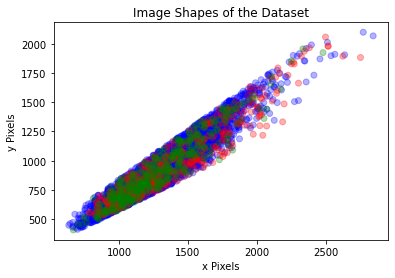

In [10]:
# Scatterplot of Width and Height parameters to show sizing
colors = df_pics['Data Set'].map({'train':'b', 'test':'r', 'valid':'g'})
fig, ax = plt.subplots()
ax.scatter(df_pics['Width'],df_pics['Height'],c=colors, alpha=0.3)
ax.set_xlabel("x Pixels")
ax.set_ylabel("y Pixels")
ax.set_title("Image Shapes of the Dataset")
plt.show()

The scatter plot reveals that the images are split between train(blue), test(red), and valid(green) data sets.  The distribution of sizes appears common between these splits

# Data Wrangling

In [11]:
# IMAGE Wrangling
# Use image data generator from keras for Training Set
train_image_gen = ImageDataGenerator(rescale = 1./255, 
                               shear_range = 0.2, 
                               zoom_range = 0.2, 
                               horizontal_flip = True)
# Use image data generator from keras for Test Set
test_image_gen = ImageDataGenerator(rescale = 1./255)
valid_image_gen = ImageDataGenerator(rescale = 1./255)

# rescale: scales array of pixel balues between [0,1]
# shear_range: shape of image transformed by fixing one axis and stretching other
# zoom_range: make image smaller if zoom <1
# horizontal_flip: Randomly flips some images horizontally

In [57]:
# IMAGE LOADING - read files from folders
# Load Training Data
train = train_image_gen.flow_from_directory(train_path, 
                                target_size=(img_height,img_width),
                                color_mode='grayscale',
                                class_mode='binary',
                                batch_size=batch_size,
                                shuffle=True)
# Load Testing Data
test = test_image_gen.flow_from_directory(test_path, 
                                target_size=(img_height,img_width),
                                color_mode='grayscale',
                                class_mode='binary',
                                batch_size=batch_size,
                                shuffle=True)

# Load Validating Data
valid = valid_image_gen.flow_from_directory(valid_path, 
                                target_size=(img_height,img_width),
                                color_mode='grayscale',
                                class_mode='binary',
                                batch_size=batch_size,
                                shuffle=True)
# target_size: resizes input image to pixel dimensions heightxwidth
# color_mode: if set to 'grayscale' set to 1 color channel for BW
# batch_size: sets number of images for each batch for the generator
#.    set to 20 to not overrun RAM space
# class_mode: 'binary' because we only have 2 output classes to predict
#.  pneumonia and normal
# Shuffle= True will randomize the files in all sets

Found 3454 images belonging to 2 classes.
Found 483 images belonging to 2 classes.
Found 384 images belonging to 2 classes.


In [66]:
# Set up the test data list along with the labels for confusion matrix later
test_data = []
test_labels = []

for kind in categories:    # kind is NORMAL or PNEUMONIA
    for img in (os.listdir(test_path+'/'+kind)):
        img = plt.imread(test_path+'/'+kind+'/'+img)
        img = cv2.resize(img,(img_height,img_width))
        #img = np.dstack([img,img,img])
        #img = img.astype('float32')/255
        if kind=='NORMAL':
            label = 0
        elif kind=='PNEUMONIA':
            label = 1
        else:
            label = 2       # error condition check for any 2 in output
        test_data.append(img)
        test_labels.append(label)
test_data = np.array(test_data)
test_labels = np.array(test_labels)

In [67]:
print(test_labels)
print(len(test_labels),len(test_data))
print(test_data[0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]
483 483
[[ 24  22  

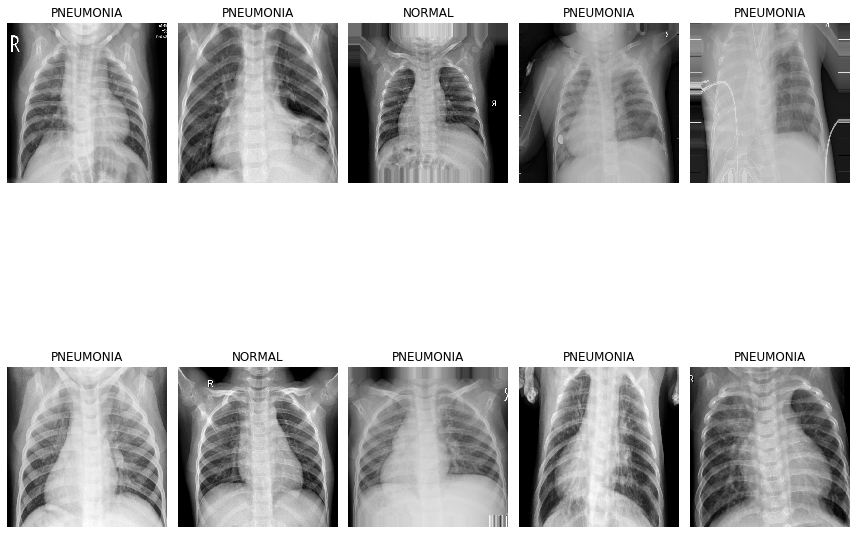

In [13]:
# View images
# Display batch of images to see results of import
plt.figure(figsize=(12,12))
for i in range(0,10):
    plt.subplot(2,5,i+1)
    for im, title in train:
        image = im[0]
        dic = {0:'NORMAL',1:'PNEUMONIA'}
        plt.title(dic.get(title[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray', interpolation='nearest')
        break
plt.tight_layout()
plt.show()

# Define methods for displaying results

In [54]:
# Display results for model
def model_results(m,td,tl,v):    # m-model, t-test data, test labels, v-validation data
    preds = m.predict(td)
    acc = accuracy_score(tl,np.round(preds))*100
    cm = confusion_matrix(tl,np.round(preds))
    tn, fp, fn, tp = cm.ravel()
    # take output of cm values to calculate precision, recall, f1
    precision = tp/(tp+fp)*100
    recall = tp/(tp+fn)*100
    f1 = 2*precision*recall/(precision+recall)
    # Display results
    print('*'*25)
    print('Confusion Matrix')
    print(cm)
    print('*'*25)
    print('Testing Metrics')
    print('%s%.2f%s'% ('Accuracy  :',acc,'%'))
    print('%s%.2f%s'% ('Precision :',precision,'%'))
    print('%s%.2f%s'% ('Recall    :',recall,'%'))
    print('%s%.2f%s'% ('F1 Score  :',f1,'%'))
    print('#'*25)

    print('Training Accuracy based on Validation Dataset')
    test_accuracy = m.evaluate(v)
    print('Model loss is : ',test_accuracy[0]*100,'%')
    print('Model Accuracy is : ',test_accuracy[1]*100,'%')
    print('*'*25)

In [15]:
# Display results on Confusion Matrix
def cm_display(m,t):
    y_pred = m.predict_generator(t,steps=len(t),verbose=True)
    y_pred = y_pred.argmax(axis=-1)
    y_true = t.classes
    cm = confusion_matrix(y_true, y_pred)
    
    fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(10,8), hide_ticks=True)
    plt.xticks(range(len(categories)),categories, fontsize=14)
    plt.yticks(range(len(categories)),categories, fontsize=14)
    plt.title("Confusion Matrix for model")
    plt.show()

# CNN Model Build
Convolutional layers: (input data image with 2D convolutional layers) Creates feature map. Depth of filter same as depth of input- grayscale is 1.  Will apply a Sequential model to allow us to build layer by layer

Determining the dimension of activation maps:
(N + 2P — F)/ S + 1; where N = Dimension of image (input) file
P = Padding
F = Dimension of filter
S = Stride

ReLu layers: (Rectified Linear Unit - linear function to output directly if positive, otherwise zero) Increases non-linearity. _Better than Sigmoid and Tanh based on overcoming the vanishing gradient problem.

Pooling layers: Combine to create spatial variance, make objects detectable no matter where they are located in the image

Flattening: make long vector of pooled features

Fully connect layer: Input vector into neural network.  Process features through the network.  The fully connected layers votes on the classes

Train the model: using forward propagation and backpropagation, trains the neural network with weights and feature detectors


In [16]:
# Create the model
model = Sequential()

# Add model layers
model.add(Conv2D(32, (3,3),
                activation='relu',kernel_initializer='he_uniform',padding='same',
                input_shape=(img_width, img_height, 1)))
model.add(MaxPooling2D((2,2)))
# number of nodes in each layer - 32
# activation - relu model for rectified linear
# input_shape - pizel size of image
# pool_size - reduce feature map by factor of 2, typically (2,2)

'''# Add another model layer to further reduce shape
model.add(Conv2D(64, (3,3),
                activation='relu',
                input_shape=(img_width, img_height, 1)))
model.add(MaxPooling2D(pool_size = (2,2)))'''
          
# Now flatten the layers
model.add(Flatten())

# Use Dense to lower shape down to 1 output
model.add(Dense(128,activation = 'relu', kernel_initializer='he_uniform'))
model.add(Dense(1,activation='sigmoid'))


In [17]:
# Compile the model
opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
#   optimizer controls the learning rate: 
#.    "Adam" good general use-adjusts lerning rate throughout training
#   loss function: binary_crossentropy, for binary (2 choice) problems
#   metrics: accuracy

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [18]:
# Look at model summary to determine layer sizes
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 500, 500, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 250, 250, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 2000000)           0         
_________________________________________________________________
dense (Dense)                (None, 128)               256000128 
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 256,000,577
Trainable params: 256,000,577
Non-trainable params: 0
_________________________________________________________________


# Fit Model

In [19]:
# Set a validation set of data to set early stopping point for model fit
early_stopping = EarlyStopping(monitor='val_loss',mode='min', patience = 3)

# hyperparameter to set how much to change model in response to error rate
# ReduceLROnPLateau: tool to adjust when plateau detected
# factor: multiplier of learning rate
# patience: How many training epochs to wait before triggering change
lrr = ReduceLROnPlateau(monitor='val_loss',patience = 3, factor=0.2)
callback_list = [early_stopping, lrr]

# look at class weights
class_weights = compute_class_weight('balanced',
                                     np.unique(train.classes),
                                     train.classes)
cw = dict(zip(np.unique(train.classes),class_weights))
print(cw)


{0: 2.3119143239625166, 1: 0.6379756187661618}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [20]:
# fit the model
model.fit(train,epochs=25,validation_data=valid, callbacks=callback_list, class_weight=cw)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/25
173/173 [==============================] - 248s 1s/step - loss: 0.8848 - accuracy: 0.3382 - val_loss: 0.6955 - val_accuracy: 0.1875
Epoch 2/25
173/173 [==============================] - 251s 1s/step - loss: 0.6935 - accuracy: 0.4502 - val_loss: 0.6960 - val_accuracy: 0.1875
Epoch 3/25
173/173 [==============================] - 253s 1s/step - loss: 0.6932 - accuracy: 0.2163 - val_loss: 0.6959 - val_accuracy: 0.1875
Epoch 4/25
173/173 [==============================] - 235s 1s/step - loss: 0.6932 - accuracy: 0.2956 - val_loss: 0.6940 - val_accuracy: 0.1875
Epoch 5/25
173/173 [==============================] - 232s 1s/step - loss: 0.6935 - accuracy: 0.6691 - val_loss: 0.6947 - val_accuracy: 0.1875
Epoch 6/25
173/173 [==============================] - 231s 1s/step - loss: 0.6932 - accuracy: 0.3958 - val_loss: 0.6951 - val_accuracy: 0.1875
Epoc

<AxesSubplot:>

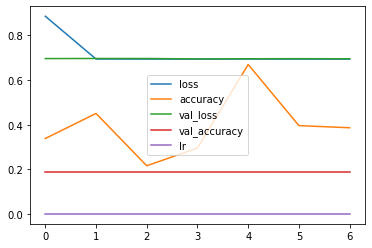

In [21]:
#Visualize the progress of the metrics throughout the epocks
pd.DataFrame(model.history.history).plot()

In [70]:
# Display Results for model 1
print('*****  Model 1  *****')
preds = model.predict(test_data)
model_results(model,test_data,test_labels,valid)

*****  Model 1  *****


ValueError: in user code:

    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1569 predict_function  *
        return step_function(self, iterator)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1559 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1552 run_step  **
        outputs = model.predict_step(data)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1525 predict_step
        return self(x, training=False)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:235 assert_input_compatibility
        str(tuple(shape)))

    ValueError: Input 0 of layer sequential is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: (None, 500, 500)


In [49]:
test.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

# Improving the Model (Model2)
The results from the first model did not meet expectations
The graph of accuracy per epoch run shows multiple initial epochs at low accuracy (18.7%)
before epoch 16 showed improvement to accuracy of (77.4%) only to see accuracy fall again
For more alignment with feature detection:
Additional layers are added to model and the Dense add will be changed to 64 units

In [24]:
# Create the model
model2 = Sequential()

# Add model layers
model2.add(Conv2D(32, (3,3),
                activation='relu',
                input_shape=(img_width, img_height, 1)))
model2.add(MaxPooling2D((2,2)))
# number of nodes in each layer - 32
# activation - relu model for rectified linear
# input_shape - pizel size of image
# pool_size - reduce feature map by factor of 2, typically (2,2)

# Add another model layer to further reduce shape
model2.add(Conv2D(32, (3,3),
                activation='relu',
                input_shape=(img_width, img_height, 1)))
model2.add(MaxPooling2D(pool_size = (2,2)))

# Add another model layer to further reduce shape
model2.add(Conv2D(64, (3,3),
                activation='relu',
                input_shape=(img_width, img_height, 1)))
model2.add(MaxPooling2D(pool_size = (2,2)))      
    
    
# Now flatten the layers
model2.add(Flatten())

# Use Dense to lower shape down to 1 output
model2.add(Dense(64,activation ='relu'))
model2.add(Dense(1,activation='sigmoid'))
# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
# fit the updated model2
model2.fit(train,epochs=25,validation_data=valid, callbacks=callback_list, class_weight=cw)

Epoch 1/25
173/173 [==============================] - 408s 2s/step - loss: 0.5129 - accuracy: 0.7533 - val_loss: 0.2690 - val_accuracy: 0.8828
Epoch 2/25
173/173 [==============================] - 315s 2s/step - loss: 0.2684 - accuracy: 0.8839 - val_loss: 0.1740 - val_accuracy: 0.9349
Epoch 3/25
173/173 [==============================] - 320s 2s/step - loss: 0.2330 - accuracy: 0.9085 - val_loss: 0.1813 - val_accuracy: 0.9427
Epoch 4/25
173/173 [==============================] - 317s 2s/step - loss: 0.2173 - accuracy: 0.9114 - val_loss: 0.1812 - val_accuracy: 0.9453
Epoch 5/25
173/173 [==============================] - 305s 2s/step - loss: 0.1915 - accuracy: 0.9215 - val_loss: 0.2504 - val_accuracy: 0.9167


In [26]:
# Look at model2 summary to determine layer sizes
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 498, 498, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 249, 249, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 247, 247, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 121, 121, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 60, 60, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 230400)           

<AxesSubplot:>

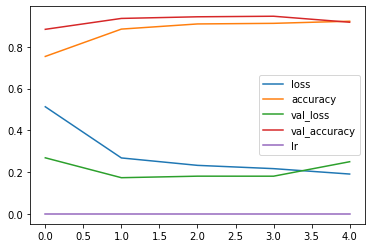

In [27]:
#Visualize the progress of the metrics throughout the epocks
pd.DataFrame(model2.history.history).plot()

In [69]:
# Display Results for model 2
print('*****  Model 2  *****')
model_results(model2,test_data,test_labels,valid)

*****  Model 2  *****


ValueError: in user code:

    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1569 predict_function  *
        return step_function(self, iterator)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1559 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1552 run_step  **
        outputs = model.predict_step(data)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1525 predict_step
        return self(x, training=False)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:235 assert_input_compatibility
        str(tuple(shape)))

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: (None, 500, 500)


# Improving the Model a third time (Model3)
The results from the second model were much better and did meet expectations
Based on the Early Stopping parameter to prevent overfitting, the model stopped at Epoch 6,
so only 6 passed through the dataset to establish model2
To test the capabilities of the model, add more Additional layers to see the result. 

In [30]:
# Create the model
model3 = Sequential()

# Add model layers
model3.add(Conv2D(32, (3,3),
                activation='relu',
                input_shape=(img_width, img_height, 1)))
model3.add(MaxPooling2D((2,2)))
# number of nodes in each layer - 32
# activation - relu model for rectified linear
# input_shape - pizel size of image
# pool_size - reduce feature map by factor of 2, typically (2,2)

# Add another model layer to further reduce shape
model3.add(Conv2D(32, (3,3),
                activation='relu',
                input_shape=(img_width, img_height, 1)))
model3.add(MaxPooling2D(pool_size = (2,2)))

# Add another model layer to further reduce shape
model3.add(Conv2D(32, (3,3),
                activation='relu',
                input_shape=(img_width, img_height, 1)))
model3.add(MaxPooling2D(pool_size = (2,2)))      

# Add another model layer to further reduce shape
model3.add(Conv2D(64, (3,3),
                activation='relu',
                input_shape=(img_width, img_height, 1)))
model3.add(MaxPooling2D(pool_size = (2,2))) 

# Add another model layer to further reduce shape
model3.add(Conv2D(64, (3,3),
                activation='relu',
                input_shape=(img_width, img_height, 1)))
model3.add(MaxPooling2D(pool_size = (2,2))) 
    
    
# Now flatten the layers
model3.add(Flatten())

# Use Dense to lower shape down to 1 output
model3.add(Dense(activation = 'relu', units=128))
model3.add(Dense(activation = 'relu', units=64))
model3.add(Dense(activation='sigmoid', units=1))
# Compile the model
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
# fit the updated model3
model3.fit(train,epochs=25,validation_data=valid, callbacks=callback_list, class_weight=cw)

Epoch 1/25
173/173 [==============================] - 296s 2s/step - loss: 0.5890 - accuracy: 0.6196 - val_loss: 0.3866 - val_accuracy: 0.8802
Epoch 2/25
173/173 [==============================] - 298s 2s/step - loss: 0.2902 - accuracy: 0.8885 - val_loss: 0.3046 - val_accuracy: 0.8880
Epoch 3/25
173/173 [==============================] - 2643s 15s/step - loss: 0.2378 - accuracy: 0.9059 - val_loss: 0.2286 - val_accuracy: 0.9193
Epoch 4/25
173/173 [==============================] - 1076s 6s/step - loss: 0.1958 - accuracy: 0.9181 - val_loss: 0.1959 - val_accuracy: 0.9323
Epoch 5/25
173/173 [==============================] - 12103s 70s/step - loss: 0.1903 - accuracy: 0.9239 - val_loss: 0.2288 - val_accuracy: 0.9167
Epoch 6/25
173/173 [==============================] - 1082s 6s/step - loss: 0.1715 - accuracy: 0.9349 - val_loss: 0.2192 - val_accuracy: 0.9245
Epoch 7/25
173/173 [==============================] - 1075s 6s/step - loss: 0.1902 - accuracy: 0.9224 - val_loss: 0.1787 - val_accuracy

In [32]:
# Look at model3 summary to determine layer sizes
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 498, 498, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 249, 249, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 247, 247, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 121, 121, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 58, 58, 64)       

<AxesSubplot:>

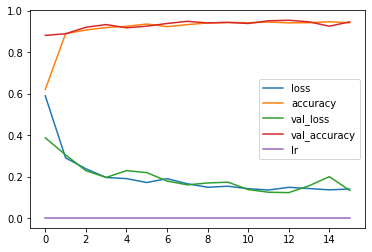

In [33]:
#Visualize the progress of the metrics throughout the epocks
pd.DataFrame(model3.history.history).plot()

In [34]:
# Display Results for model 3
print('*****  Model 3  *****')
model_results(model3,test_data,test_labels,valid)

*****  Model 3  *****


/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


25/25 [==============================] - 8s 311ms/step
*************************
Results Report
#########################
Precision :0.00%
Recall    :0.00%
F1 Score  :0.00%
#########################
Test Accuracy based on Validation Dataset


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


20/20 [==============================] - 6s 304ms/step - loss: 0.1334 - accuracy: 0.9453
Test Accuracy is :  94.53125 %
